In [112]:
import os
import sys
import cv2
import numpy as np
import torch
import torch.utils.data
import matplotlib.pyplot as plt
import plotly
import plotly.offline as po
import plotly.graph_objs as go

In [113]:
body_joints = np.load('data/keypoints/triangulation.pickle', allow_pickle=True)
with np.load("data/frames/2023-01-17-livingroom/venue-info/marker_corners.npz") as marker_data:
    marker_info = {
                    "valid_ids": marker_data["valid_ids"],
                    "corners": marker_data["corners"],
    }
camera_poses = np.load("data/frames/2023-01-17-livingroom/venue-info/params.pickle", allow_pickle=True)

In [114]:
body_joints_0117 = body_joints['2023-01-17-livingroom']['take1']
print(body_joints_0117.__len__())

4578


In [115]:
nose = 0
left_eye = 1
right_eye = 2
left_ear = 3
right_ear = 4
left_shoulder = 5
right_shoulder = 6
left_elbow = 7
right_elbow = 8
left_wrist = 9
right_wrist = 10
left_hip = 11
right_hip = 12
left_knee = 13
right_knee = 14
left_ankle = 15
right_ankle = 16
connected_keys = [
    [nose, left_eye],
    [nose, right_eye],
    [left_eye, left_ear],
    [right_eye, right_ear],
    [left_eye, left_shoulder],
    [right_eye, right_shoulder],
    [left_shoulder, left_elbow],
    [left_shoulder, right_shoulder],
    [right_shoulder, right_elbow],
    [left_elbow, left_wrist],
    [right_elbow, right_wrist],
    [left_shoulder, left_hip],
    [right_shoulder, right_hip],
    [left_hip, right_hip],
    [left_hip, left_knee],
    [right_hip, right_knee],
    [left_knee, left_ankle],
    [right_knee, right_ankle],
]

In this session, marker 96 is placed on a table. So we use this as the z=0 plane for better visualization.

In [116]:
# z-plane alignment
from skimage.transform import SimilarityTransform, EuclideanTransform
def absolute_orientation(p, q, no_scaling=False):
    """
    Returns R, t, s satisfying q = s * R * p + t

    p and q must be 3xN matrices.
    """

    if no_scaling:
        st = EuclideanTransform()
    else:
        st = SimilarityTransform()

    st.estimate(p.T, q.T)
    R = st.params[:3, :3]
    t = st.params[:3, 3]
    s = np.linalg.norm(R) / np.sqrt(3)
    R = R / s
    return R, t, s

SCALE = 1
X = np.array( [
    [ -SCALE/2,  SCALE/2, 0 ], # TL
    [  SCALE/2,  SCALE/2, 0 ], # TR
    [  SCALE/2, -SCALE/2, 0 ], # BR
    [ -SCALE/2, -SCALE/2, 0 ], # BL
    ] ).T
Y = marker_info['corners'][96].T
R, t, s = absolute_orientation(Y, X)

We plot body keypoints, marker corners and camera positions in each of the cells below, after applying z-plane alignment.

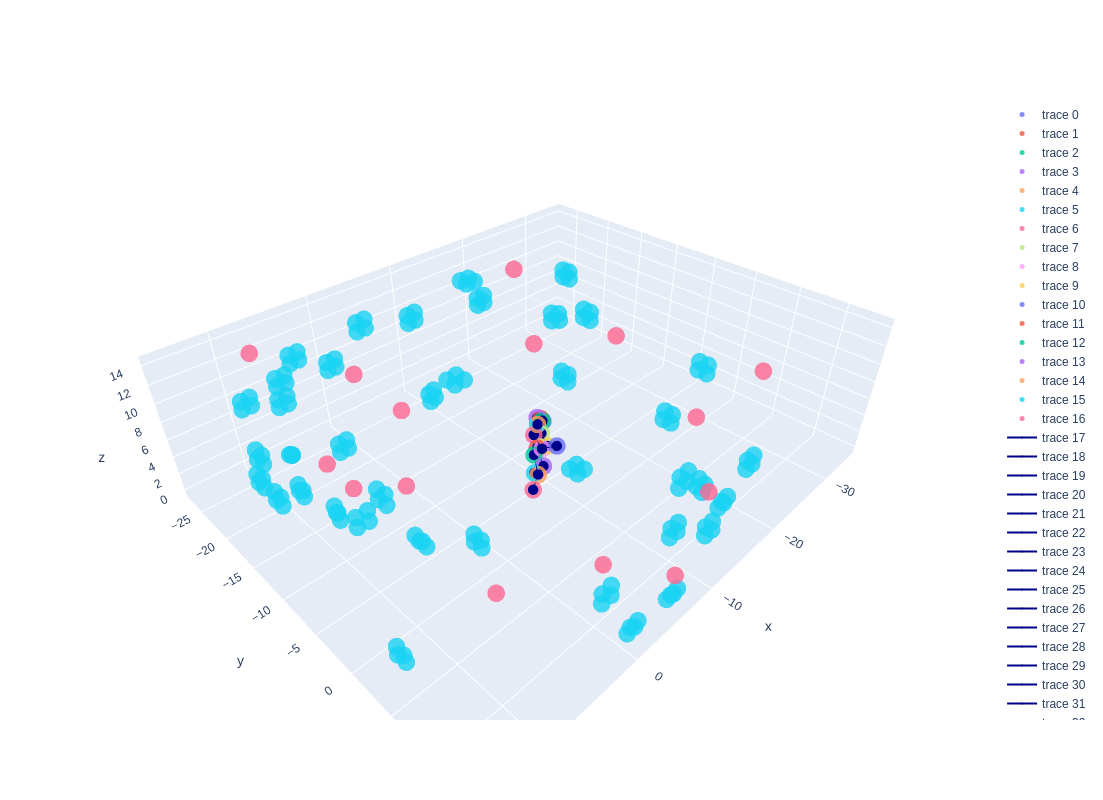

In [165]:
data = list()

# Plot body keypoints
keys = list(range(17))
time = list(range(10,11,50))
for t in time:
    for key in keys:
        x,y,z = s*R@body_joints_0117[t].T[key]+t
        data.append(go.Scatter3d(x=[x],y=[y],z=[z],mode='markers',marker=dict(size=5,color=key,colorscale='Viridis', opacity=0.8)))
    for i,j in connected_keys:
        coords = np.array((body_joints_0117[t].T[i],body_joints_0117[t].T[j]))
        x,y,z = s*R@coords.T+t
        data.append(go.Scatter3d(x=x,y=y,z=z,marker=dict(size=0),line=dict(color='darkblue', width=2)))

# Plot marker corners
valid_corners = marker_info['corners'][marker_info['valid_ids']]
valid_corners = valid_corners.reshape(-1,3)
x,y,z = s*R@valid_corners.T+t
data.append(
    go.Scatter3d(x=x,y=y,z=z,mode="markers",marker=dict(size=5,color=17,colorscale="Viridis",opacity=0.8),)
)

# plot camera positions
poses = list()
for pose in camera_poses.values():
    poses.append(pose['t'])
poses = np.array(poses).T
x,y,z=s*R@poses+t
data.append(
    go.Scatter3d(x=x,y=y,z=z,mode="markers",marker=dict(size=5,color=18,colorscale="Viridis",opacity=0.8),)
)

fig = go.Figure(data=data)
fig.update_layout(width=1200, height=800)
fig.show()